In [1]:
import OffsetArrays
using Plots
using Revise
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using IterTools
using DelimitedFiles
using LaTeXStrings

In [2]:
200/7*12

342.8571428571429

# Paper Plots

In [3]:
function read_inference(samp, xmin, xmax, ymin, ymax; obs_inf=true,T=8, d=3, graph = "er", grid_x=21, grid_y=21)
    AUCtitle = obs_inf ? "AUC" : "AUCNO" 
    path = "./dil_lam_$(graph)_$(samp)/"
    yRange = LinRange(ymin,ymax,grid_y)
    xRange = LinRange(xmin,xmax,grid_x)
    ninf = readdlm("$(path)ninf.txt")
    Fe = readdlm("$(path)Fe.txt")
    AUC = zeros(grid_y,grid_x,T+2)
    Ov = zeros(grid_y,grid_x,T+2)
    L1 = zeros(grid_y,grid_x,T+2)
    MSE = zeros(grid_y,grid_x,T+2)
    for t = 2 : T + 2 
        AUC[:,:,t] .= readdlm("$(path)AUC$(t - 1).txt") 
        Ov[:,:,t] .= readdlm("$(path)Ov$(t - 1).txt") 
        L1[:,:,t] .= readdlm("$(path)L1_$(t - 1).txt") 
        MSE[:,:,t] .= readdlm("$(path)MSE$(t - 1).txt") 
    end
    AUC[isnan.(AUC)] .= 1
    Ov .= 2 .* Ov .- 1
    hiter = heatmap(xRange,yRange,ninf,title="iterations")
    hfe = heatmap(xRange,yRange,Fe)
    #hλinfer = heatmap(xRange,yRange,λinfer,title="λ infer")
    #hγinfer = heatmap(xRange,yRange,γinfer,title="γ infer")
    hAUC = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)
    hOv = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)
    hL1 = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)
    hMSE = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)

    for t = 2 : T + 2 
        hAUC[t-1] = heatmap(xRange,yRange,AUC[:,:,t],title="$(AUCtitle)(t=$(t-2))",clims=(0.5,1.0)) 
        hOv[t-1] = heatmap(xRange,yRange,Ov[:,:,t],title="MMO(t=$(t-2))",clims=(0.0,1.0)) 
        hL1[t-1] = heatmap(xRange,yRange,L1[:,:,t],title="L1(t=$(t-2))",clims=(minimum(L1),maximum(L1))) 
        hMSE[t-1] = heatmap(xRange,yRange,MSE[:,:,t],title="MMSE(t=$(t-2))",clims=(0.0,0.25)) 
    end
    return hAUC, hOv, hL1, hMSE, hiter, hfe
end

read_inference (generic function with 1 method)

# First Plot: comparison Measures

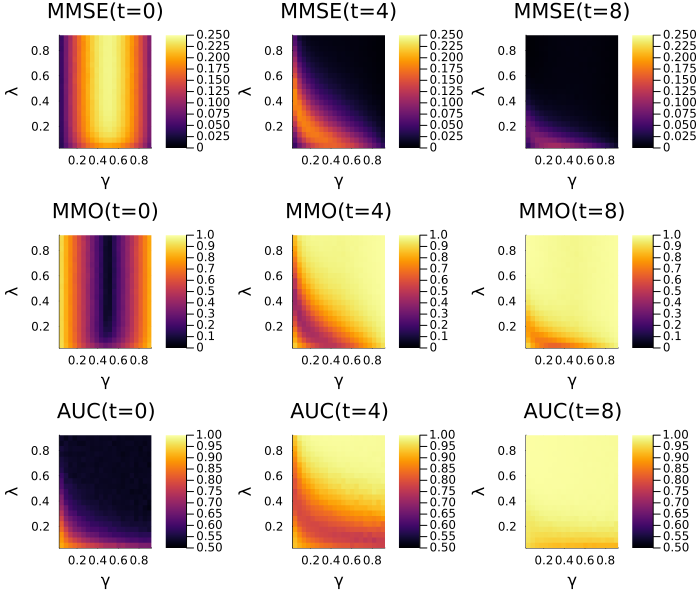

In [4]:
samp = 22
xmin = ymin = 0.05
xmax = ymax = 0.9
hAUC, hOv, hL1, hMSE, hiter, hfe = read_inference(samp, xmin, xmax, ymin, ymax)
plot(hMSE[1],hMSE[5],hMSE[end],hOv[1],hOv[5],hOv[end],hAUC[1],hAUC[5],hAUC[end], size=(700,600),layout = (3,3),xlabel="γ",ylabel="λ",margin=Plots.mm)
#savefig("comp_measures.pdf")

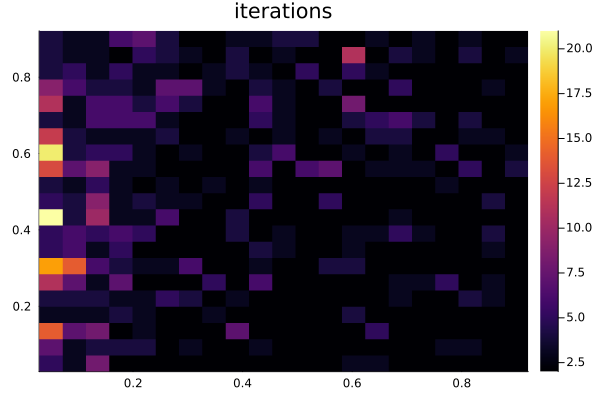

In [5]:
hiter

# First Plot for other ensembles

In [6]:
t = 3
pRR = plot(hMSERR[t],title="RR")
pER = plot(hMSE[t],title="ER")
pFT = plot(hMSEFT[t],title="FT")
plot(pRR,pER,pFT,layout=(1,3),size=(800,200),xlabel="γ",ylabel="λ",margin=5Plots.mm)
#savefig("comp_ens_graphs.pdf")

LoadError: UndefVarError: hMSERR not defined

# Second Plot: AUC vs AUCNO

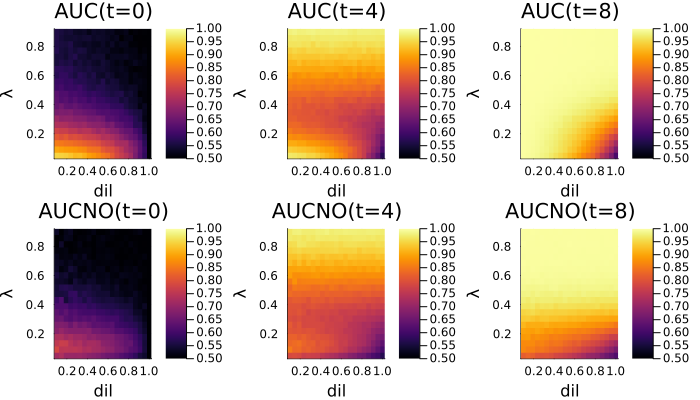

In [7]:
ymin =  0.05
ymax =  0.9
xmin =  0.1
xmax =  1.0
samp = 18
hAUCNO, hOv, hL1, hMSE, hiter, hfe = read_inference(samp, xmin, xmax, ymin, ymax,obs_inf=false)
samp = 19
hAUC, hOv, hL1, hMSE, hiter, hfe= read_inference(samp, xmin, xmax, ymin, ymax)
plot(hAUC[1],hAUC[5],hAUC[end],hAUCNO[1],hAUCNO[5],hAUCNO[end], size=(700,400),layout = (2,3),xlabel="dil",ylabel="λ",margin=Plots.mm)
#savefig("AUCvsAUCNO.pdf")

# Third Plot: free energies

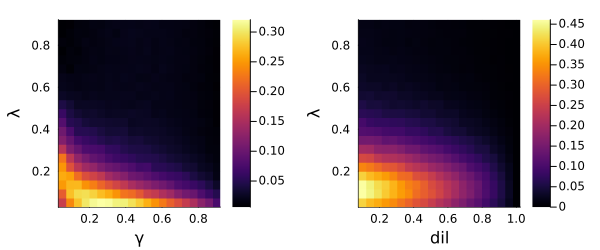

In [8]:
xmin =  0.1
xmax =  1.0
ymin = 0.05
ymax = 0.9
samp = 18
hAUCNO, hOv, hL1, hMSE, hiter, hfe = read_inference(samp, xmin, xmax, ymin, ymax,obs_inf=false)
pfedil = plot(hfe,xlabel="dil",ylabel="λ")
samp = 20
xmin = ymin 
xmax = ymax  
hAUC, hOv, hL1, hMSE, hiter, hfe = read_inference(samp, xmin, xmax, ymin, ymax)
pfegam = plot(hfe,xlabel="γ",ylabel="λ")
plot(pfegam,pfedil, size=(600,250),margin=3Plots.mm)
#savefig("free_energies.pdf")

# Fourth Plot: RSB

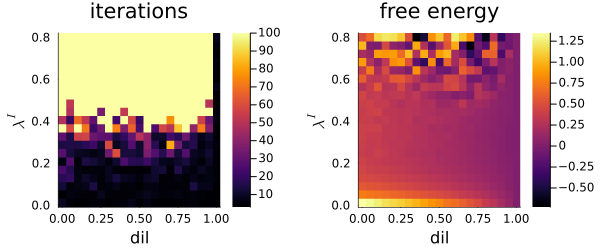

In [10]:
xmin =  0.0
xmax =  1.0
ymin = 0.01
ymax = 0.8
samp = 8  #quando lo hai prova 14
hAUCNO, hOv, hL1, hMSE, hiter, hfe = read_inference(samp, xmin, xmax, ymin, ymax,obs_inf=false)
pfe = plot(hfe,title="free energy")
plot(hiter,pfe, size=(600,250),margin=3Plots.mm,xlabel="dil",ylabel=L"\lambda^I")
#savefig("RSB.pdf")

# Fifth Plot: optimal vs learn

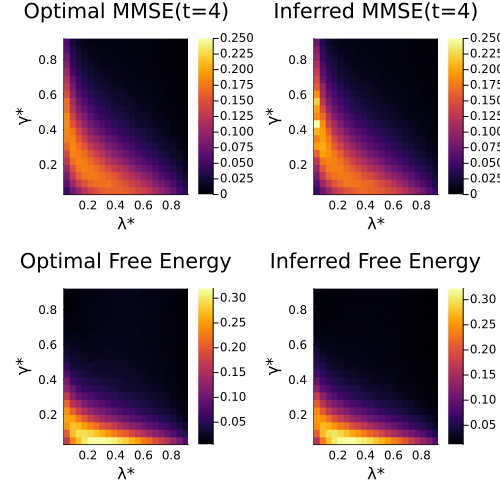

In [12]:
xmin =  0.05
xmax =  0.9
ymin = 0.05
ymax = 0.9
samp = 17
hAUC, hOv, hL1, hMSE, hiter, hfe = read_inference(samp, xmin, xmax, ymin, ymax)
pfe = plot(hfe,title="Inferred Free Energy")
pmse = plot(hMSE[5], title="Inferred MMSE(t=4)") 
samp = 22
hAUC, hOv, hL1, hMSEopt, hiter, hfeopt = read_inference(samp, xmin, xmax, ymin, ymax)
pfeopt = plot(hfeopt,title="Optimal Free Energy")
pmseopt = plot(hMSEopt[5], title="Optimal MMSE(t=4)") 
plot(pmseopt,pmse,pfeopt,pfe, size=(500,500),xlabel="λ*",ylabel="γ*",layout = (2,2),left_margin=2Plots.mm)
#savefig("gam_vs_lam_learn.pdf")

# Sixth Plot: distance ($\gamma,\lambda$)

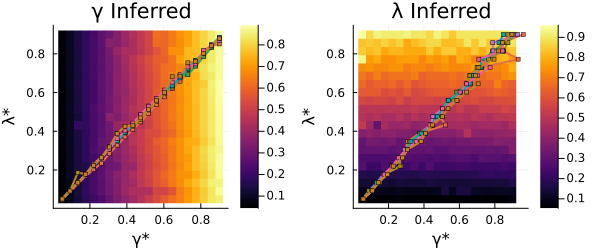

In [13]:
xmin =  0.05
xmax =  0.9
ymin = 0.05
ymax = 0.9
graph = "er"
samp = 24 
path = "./dil_lam_$(graph)_$(samp)/"
λinfer = readdlm("$(path)infλ.txt")
γinfer = readdlm("$(path)infγ.txt")
γRange = LinRange(xmin,xmax,21)
λRange = LinRange(ymin,ymax,21)
λtrue = λRange .* ones(size(λinfer))
γtrue = (γRange .* ones(size(γinfer)))'
hλ = heatmap(γRange,λRange,λinfer,xlabel="γ*",ylabel="λ*",title="λ Inferred")
#col=[:blue,:black,:red,:orange,:green,:purple,:grey,:white]
for st = 1:3:21
    hλ = plot!(λinfer[:,st],marker=:c,markersize=2,λRange,label=false)
end
hγ = heatmap(γRange,λRange,γinfer,xlabel="γ*",ylabel="λ*",title="γ Inferred")
for st = 1:3:21
    hγ = plot!(γRange,γinfer[st,:],label=false)
end

plot(hγ,hλ,size=(600,250),width=2,marker=:square,markersize=2,left_margin=1.7Plots.mm,bottom_margin=2.7Plots.mm)

#hL2 = heatmap(x,y,sqrt.((λinfer .- λtrue) .^ 2 + (γinfer .- γtrue') .^ 2 ) ./ sqrt.(λtrue^2 .+ γtrue'^2) ,ylabel="λ",xlabel="γ")
#savefig("InferenceHyper.pdf")

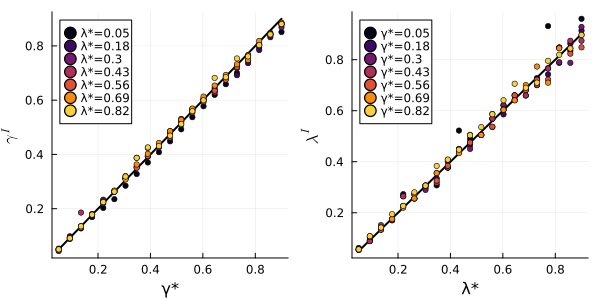

In [14]:
p1 = plot(λRange,λRange,label=false,color=:black,width=2)
#C(g::ColorGradient) = RGB[g[z] for z=LinRange(0,1,30)]
g = :inferno
for st = 1:3:21
    p1 = scatter!(λRange,λinfer[:,st],marker=cgrad(g)[st*12],markersize=3,colorscale=:blues,label="γ*=$(round(γRange[st],digits=2))",xlabel="λ*",ylabel=L"\lambda^I")
end
p2 = plot(γRange,γRange,label=false,color=:black,width=2)
for st = 1:3:21
    p2 = scatter!(γRange,γinfer[st,:],marker=cgrad(g)[st*12],markersize=3,color=:blues,label="λ*=$(round(λRange[st],digits=2))",xlabel="γ*",ylabel=L"γ^I")
end
plot(p2,p1,size=(600,300),bottom_margin=2Plots.mm)
#savefig("InferenceHyper.pdf")

# Seventh Plot: comparison sib VS ens

In [15]:
using Interpolations
function read_sib(graph,N,dil,t;T=8,d=3)
    pathtest = "../examples/MSEsibylN=$N/"
    name = Dict("er" => "poisson", "rr" => "regular")
    sib = readdlm("$(pathtest)$(graph)_MSE$(t)_dil_$(dil).txt")
    return sib
end
function read_sibMSE(graph,N,dil,t;T=8,d=3)
    pathtest = "../examples/MSEsibylN=$N/"
    name = Dict("er" => "poisson", "rr" => "regular")
    sib = readdlm("$(pathtest)$(graph)_MSE$(t)_dil_$(dil).txt")
    return sib
end
function read_ens(graph,t;T=8,d=3,samp=26)
    ensemble = readdlm("dil_lam_$(graph)_$(samp)/MSE$(t).txt")
end
function n_infected(graph;T=8,d=3)
    ni = readdlm("./infected/ni_$(graph)_T=$(T)_d=$(d)_lam0.01_1.0.txt")
    itp = LinearInterpolation(LinRange(0.01,1,100),vec(ni));
    ni = [itp(t) for t in LinRange(0.01,0.4,41)];
end

n_infected (generic function with 1 method)

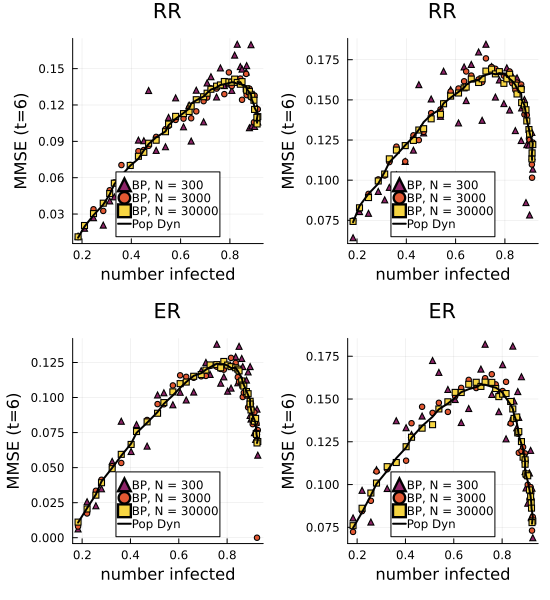

In [17]:
g = cgrad(:inferno)

graph,N,dil,t = "er", 300, 0.5, 6
sib300 = read_sib(graph,N,dil,t);
N = 3000
sib3000 = read_sib(graph,N,dil,t);
N = 30000
sib30000 = read_sib(graph,N,dil,t);
ens = read_ens(graph,t,samp=26);
ni = n_infected(graph)

p_er_05 = scatter(ni,sib300,color=g[100],marker=:utriangle,markersize=3,label="BP, N = 300")
p_er_05 = scatter!(ni,sib3000,color=g[160],markersize=3,label="BP, N = 3000")
p_er_05 = scatter!(ni,sib30000,color=g[230],marker=:square,markersize=3,label="BP, N = 30000")
p_er_05 = plot!(ni,ens[:,2],ylabel="MMSE (t=$t)",width=2,label="Pop Dyn",title="ER",color=:black,xlabel="number infected")

graph,N,dil,t = "er", 300, 0.0, 6
sib300 = read_sib(graph,N,dil,t);
N = 3000
sib3000 = read_sib(graph,N,dil,t);
N = 30000
sib30000 = read_sib(graph,N,dil,t);
ens = read_ens(graph,t,samp=26);
ni = n_infected(graph)

p_er_0 = scatter(ni,sib300,color=g[100],markersize=3,marker=:utriangle,label="BP, N = 300")
p_er_0 = scatter!(ni,sib3000,color=g[160],markersize=3,label="BP, N = 3000")
p_er_0 = scatter!(ni,sib30000,color=g[230],markersize=3,marker=:square,label="BP, N = 30000")
p_er_0 = plot!(ni,ens[:,1],ylabel="MMSE (t=$t)",width=2,label="Pop Dyn",title="ER",color=:black,xlabel="number infected")

graph,N,dil,t = "rr", 300, 0.5, 6
sib300 = read_sib(graph,N,dil,t);
N = 3000
sib3000 = read_sib(graph,N,dil,t);
N = 30000
sib30000 = read_sib(graph,N,dil,t);
ens = read_ens(graph,t);
ni = n_infected(graph)

p_rr_05 = scatter(ni,sib300,color=g[100],markersize=3,marker=:utriangle,label="BP, N = 300")
p_rr_05 = scatter!(ni,sib3000,color=g[160],markersize=3,label="BP, N = 3000")
p_rr_05 = scatter!(ni,sib30000,color=g[230],markersize=3,marker=:square,label="BP, N = 30000")
p_rr_05 = plot!(ni,ens[:,2],ylabel="MMSE (t=$t)",width=2,label="Pop Dyn",title="RR",color=:black,xlabel="number infected")

graph,N,dil,t = "rr", 300, 0.0, 6
sib300 = read_sib(graph,N,dil,t);
N = 3000
sib3000 = read_sib(graph,N,dil,t);
N = 30000
sib30000 = read_sib(graph,N,dil,t);
ens = read_ens(graph,t,samp=26);
ni = n_infected(graph)


p_rr_0 = scatter(ni,sib300,color=g[100],marker=:utriangle,markersize=3,label="BP, N = 300")
p_rr_0 = scatter!(ni,sib3000,color=g[160],markersize=3,label="BP, N = 3000")
p_rr_0 = scatter!(ni,sib30000,color=g[230],marker=:square,markersize=3,label="BP, N = 30000")
p_rr_0 = plot!(ni,ens[:,1],ylabel="MMSE (t=$t)",width=2,label="Pop Dyn",title="RR",color=:black,xlabel="number infected")

plot(p_rr_0,p_rr_05,p_er_0,p_er_05,layout=(2,2),markersize=3,size=(550,600),margin=Plots.mm,legend=:bottom)
#savefig("sib_vs_ens.pdf")

# Eighth plot: false rate VS dilution

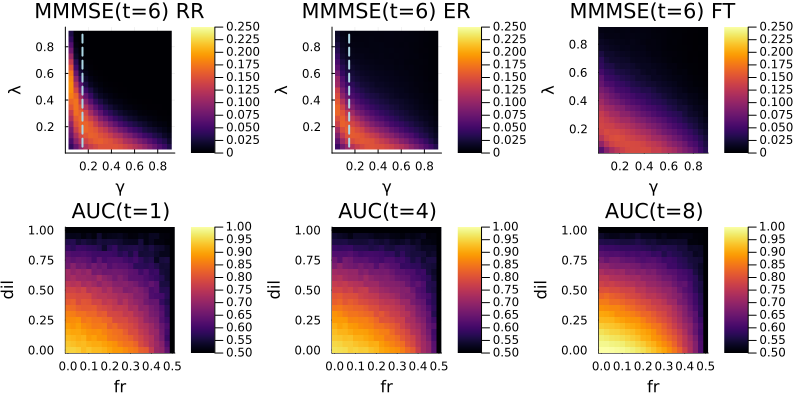

In [18]:
samp = 22
xmin = ymin = 0.05
xmax = ymax = 0.9
hAUCRR, hOvRR, hL1RR, hMSERR, hiterRR, hfeRR = read_inference(samp, xmin, xmax, ymin, ymax,graph="rr")
hAUC, hOv, hL1, hMSE, hiter, hfe = read_inference(samp, xmin, xmax, ymin, ymax,graph="er")
hAUCFT, hOvFT, hL1FT, hMSEFT, hiterFT, hfeFT = read_inference(samp, xmin, xmax, ymin, ymax,graph="ft")
pRR = plot(hMSERR[6],title="MMMSE(t=6) RR",xlabel="γ",ylabel="λ")
plot!(0.15 * ones(21),LinRange(ymin,ymax,21),label=false,linestyle=:dash,width=2,color=:blues)
pER = plot(hMSE[6],title="MMMSE(t=6) ER",xlabel="γ",ylabel="λ")
plot!(0.15 * ones(21),LinRange(ymin,ymax,21),label=false,linestyle=:dash,width=2,color=:blues)
pFT = plot(hMSEFT[6],title="MMMSE(t=6) FT",xlabel="γ",ylabel="λ")

samp = 29
xmin = ymin = 0.0
xmax = 0.5
ymax = 1.0
hAUC, hOv, hL1, hMSE, hiter, hfe = read_inference(samp, xmin, xmax, ymin, ymax,graph="er",grid_x=21,grid_y=21)
#plot!(0.15 * ones(21),LinRange(ymin,ymax,21),label=false,linestyle=:dash,width=3,color=:blues)
hAUC2 = plot(hAUC[2],xlabel="fr",ylabel="dil") 
hAUC5 = plot(hAUC[5],xlabel="fr",ylabel="dil") 
hAUC9 = plot(hAUC[9],xlabel="fr",ylabel="dil")
plot(pRR,pER,pFT,hAUC2,hAUC5,hAUC9,layout=(2,3),size=(800,400),left_margin=2Plots.mm,bottom_margin=3Plots.mm)
#savefig("comp_graphs_fr.pdf")

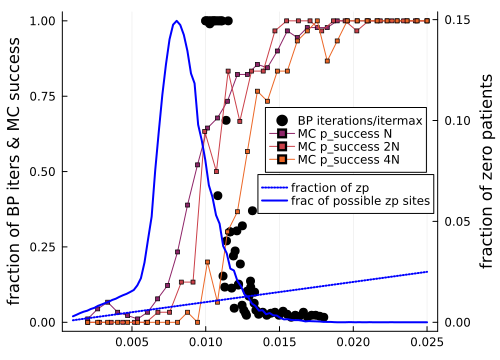

In [24]:
g = cgrad(:inferno)
γ = LinRange(0.01,0.025,12) 
γfiner = LinRange(0.01,0.018,30) 
γmorefiner = LinRange(0.01,0.0134,30) 


iters4 = readdlm("dil_lam_rr_32/ninf.txt")
iters8 = readdlm("dil_lam_rr_34/ninf.txt")
iters4finer = readdlm("dil_lam_rr_35/ninf.txt")
iters4morefiner = readdlm("dil_lam_rr_30/ninf.txt")

MC_2e3 = readdlm("../examples/N=2000MC.txt")
MC_5e3 = readdlm("../examples/N=5000MC.txt")
MC_1e4 = readdlm("../examples/N=10000MC.txt")
MC_2e4 = readdlm("../examples/N=20000MC.txt")
MCγ = LinRange(0.002,0.025,30)
N = Int(4 * 10^4)
n_zp4_4 = readdlm("../examples/N=$(N)n_zp.txt")
N = Int(4 * 10^5)
n_zp4_5 = readdlm("../examples/N=$(N)n_zp.txt") 
N = Int(4 * 10^6)
n_zp4_6 = readdlm("../examples/N=$(N)n_zp.txt")
N = Int(4 * 10^7)
n_zp4_7 = readdlm("../examples/N=$(N)n_zp.txt")

p = plot()
p_twin = twinx(p)

BPmarker = :c
BPsize = 5
#plot(γ,iters2[2,:],marker=:square,linestyle=:dash,label="iters pop = 2e5 ")
p0 = scatter(p,γ,iters4'./300,c=:black,width=2,marker=BPmarker,linestyle=:dot,markersize=BPsize,label=false)
p0 = scatter!(p,ylabel="fraction of BP iters & MC success",γfiner,iters4finer'./300,c=:black,width=2,linestyle=:dot,marker=BPmarker,markersize=BPsize,label=false)
p0 = scatter!(p,γmorefiner,iters4morefiner'./300,c=:black,width=2,linestyle=:dash,marker=BPmarker,markersize=BPsize,label="BP iterations/itermax",legend=(0.63,0.66))
#p0 = plot!(p,LinRange(0.002,0.025,35),MC_2e3,c = g[70],label="MC p_success N",marker=:sq,markersize=2)
p0 = plot!(p,LinRange(0.002,0.025,35),MC_5e3,c = g[100],label="MC p_success N",marker=:sq,markersize=2)
p0 = plot!(p,MCγ,MC_1e4,c = g[140],label="MC p_success 2N",width=1,marker=:sq,markersize=2)
p0 = plot!(p,LinRange(0.002,0.025,35),MC_2e4,c = g[170],label="MC p_success 4N",width=1,marker=:sq,markersize=2)
p0 = plot!(p_twin,ylabel="",LinRange(0.001,0.025,100),LinRange(0.001,0.025,100),c=:blue,width=2,linestyle=:dot,label="fraction of zp")

#p0 = plot!(p_twin,LinRange(0.001,0.025,100) ,n_zp4_5,markersize=3,width=2,c=g[90],label="frac of possible zp sites",xlim=(0.003,0.025))
p0 = plot!(p_twin,LinRange(0.001,0.025,100) ,n_zp4_6,markersize=3,ylabel="fraction of zero patients",width=2,c=:blue,label="frac of possible zp sites",legend=(0.61,0.45))
#p0 = plot!(p_twin,LinRange(0.001,0.025,100) ,n_zp4_7,markersize=3,width=2,c=g[200],label="frac of possible zp sites",legend=(0.62,0.58))
plot(p0,size=(500,360))

In [26]:
#savefig("non_converg.pdf")

# plot for psus

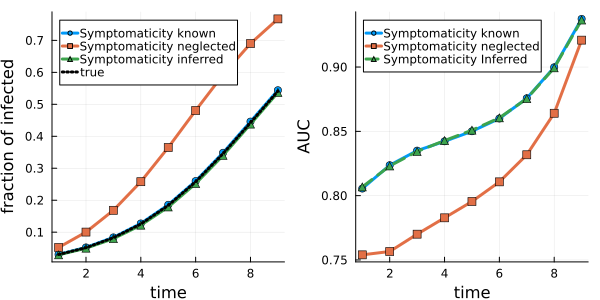

In [25]:
ensAUC = readdlm("../examples/AUCsympt.txt")
ensAUC1 = readdlm("../examples/AUCsymptneg.txt")
ensAUCinf = readdlm("../examples/AUCsymptinf.txt")
fracsympt = readdlm("../examples/fracsympt.txt")
fracsymptneg = readdlm("../examples/fracneg.txt")
fracsymptinf = readdlm("../examples/fracinf.txt")
fracsympttrue = readdlm("../examples/fractrue.txt")

p1 = plot(ensAUC,label="Symptomaticity known",marker=:c)
p1 = plot!(ensAUC1,label="Symptomaticity neglected",marker=:square,ylabel="AUC",linewidth=3)
p1 = plot!(ensAUCinf,label="Symptomaticity Inferred",linestyle=:dash,marker=:utriangle)

p0 = plot(fracsympt,marker=:circle,legend=:topleft,label="Symptomaticity known",ylabel="fraction of infected")
p0 = plot!(fracsymptneg,marker=:square,label="Symptomaticity neglected")
p0 = plot!(fracsymptinf,marker=:utriangle,label="Symptomaticity inferred")
p0 = plot!(fracsympttrue,c=:black,linestyle=:dot,label="true")

plot(p0,p1,size=(600,300),linewidth=3,xlabel="time")
#savefig("./obs_trig.pdf")